In [211]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report
import subprocess
import joblib

In [212]:
#get multiple output in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [213]:
#import dataset
churn = pd.read_csv("Churn_Modelling.csv")

## Data exploration

In [214]:
#overview of the data
print("Dataset Overview:")
print(churn.head())

#shape
print("\nDataset Shape:")
print(churn.shape)

#check for Nan
print("\nMissing Values:")
print(churn.isnull().sum())

#check data types
print("\nData Types:")
print(churn.dtypes)

#summary statistics
print("\nSummary Statistics:")
print(churn.describe())

#categorical columns
categorical_columns = churn.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(churn[col].value_counts())



Dataset Overview:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63      

<Figure size 800x600 with 0 Axes>

(array([ 142.,  469., 1030., 1149., 1819., 1810.,  984.,  887.,  568.,
         260.,  294.,  229.,  130.,   78.,   79.,   48.,   12.,    8.,
           2.,    2.]),
 array([18. , 21.7, 25.4, 29.1, 32.8, 36.5, 40.2, 43.9, 47.6, 51.3, 55. ,
        58.7, 62.4, 66.1, 69.8, 73.5, 77.2, 80.9, 84.6, 88.3, 92. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Distribution of Age')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Count')

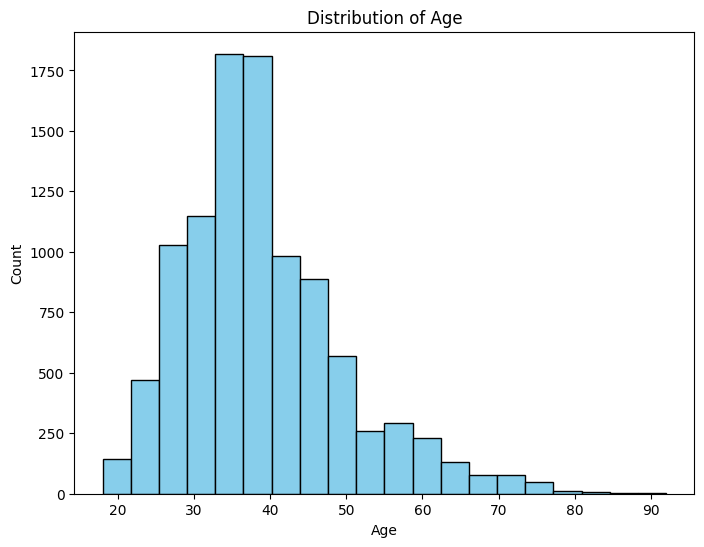

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Distribution of Gender')

Text(0.5, 0, 'Gender')

Text(0, 0.5, 'Count')

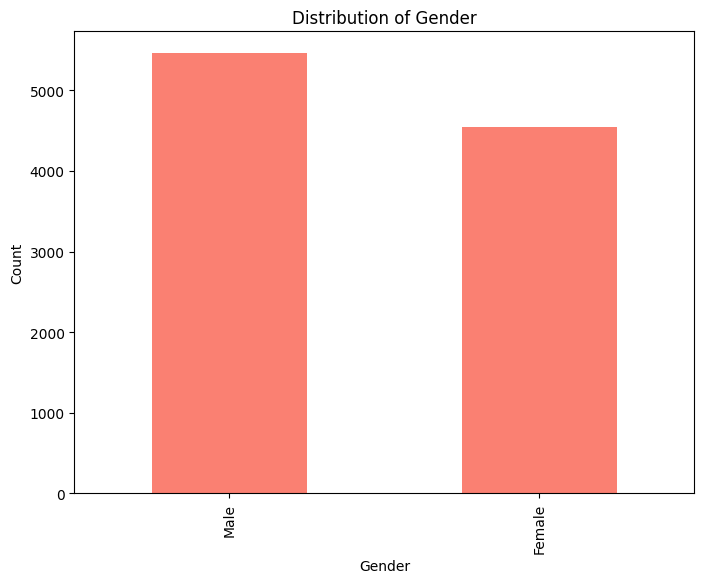

<ipython-input-215-b9c712bc4559>:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = churn.corr()


<Figure size 1000x800 with 0 Axes>

Text(0.5, 1.0, 'Correlation Matrix')

([<matplotlib.axis.XTick at 0x78b2b6c86fe0>,
 [Text(0, 1, 'RowNumber'),
  Text(1, 1, 'CustomerId'),
  Text(2, 1, 'CreditScore'),
  Text(3, 1, 'Age'),
  Text(4, 1, 'Tenure'),
  Text(5, 1, 'Balance'),
  Text(6, 1, 'NumOfProducts'),
  Text(7, 1, 'HasCrCard'),
  Text(8, 1, 'IsActiveMember'),
  Text(9, 1, 'EstimatedSalary'),
  Text(10, 1, 'Exited')])

([<matplotlib.axis.YTick at 0x78b2b6c86e30>,
 [Text(0, 0, 'RowNumber'),
  Text(0, 1, 'CustomerId'),
  Text(0, 2, 'CreditScore'),
  Text(0, 3, 'Age'),
  Text(0, 4, 'Tenure'),
  Text(0, 5, 'Balance'),
  Text(0, 6, 'NumOfProducts'),
  Text(0, 7, 'HasCrCard'),
  Text(0, 8, 'IsActiveMember'),
  Text(0, 9, 'EstimatedSalary'),
  Text(0, 10, 'Exited')])

<Figure size 1000x800 with 0 Axes>

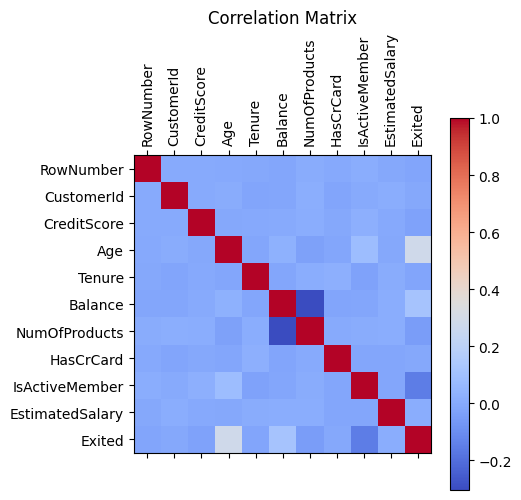

In [215]:
# Data visualization

#age
plt.figure(figsize=(8, 6))
plt.hist(churn['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

#gender
plt.figure(figsize=(8, 6))
churn['Gender'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


#correlation matrix
correlation_matrix = churn.corr()
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

## Data Preprocessing

In [216]:
#churn = pd.read_csv("Churn_Modelling.csv")

remove = ["RowNumber"] #don't bring anything relevant to the analysis
churn.drop(remove, axis=1)

y = churn['Exited'] #target variable

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [217]:
#categorical variable gender
le = LabelEncoder()
churn["Gender"] = le.fit_transform(churn["Gender"])
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [218]:
#test set aside
churn_train_val, churn_test, y_train_val, y_test = train_test_split(churn, y.ravel(), test_size = 0.1, random_state = 42)

#splitting into train and validation set
churn_train, churn_val, y_train, y_val = train_test_split(churn_train_val, y_train_val, test_size = 0.12, random_state = 42)
churn_train.shape, churn_val.shape, churn_test.shape, y_train.shape, y_val.shape, y_test.shape

np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 14), (1080, 14), (1000, 14), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

In [219]:
churn_train_val_CUSTID = churn_train_val[['CustomerId',"Surname"]]
churn_val_CUSTID = churn_val[['CustomerId',"Surname"]]
churn_test_CUSTID = churn_test[['CustomerId',"Surname"]]


In [220]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le_ohe = LabelEncoder()
ohe = OneHotEncoder(sparse=False)
ohe_train = ohe.fit_transform(le_ohe.fit_transform(churn_train['Geography']).reshape(-1, 1))
le_ohe_geography_mapping = dict(zip(le_ohe.classes_, range(len(le_ohe.classes_))))
le_ohe_geography_mapping


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'France': 0, 'Germany': 1, 'Spain': 2}

In [221]:
#validation + test set
enc_val = churn_val['Geography'].map(le_ohe_geography_mapping).fillna(9999).astype(int).values.reshape(-1, 1)
enc_test = churn_test['Geography'].map(le_ohe_geography_mapping).fillna(9999).astype(int).values.reshape(-1, 1)

ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)


In [222]:
#new columns
cols = ['country_' + str(x) for x in le_ohe_geography_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [223]:
#adding to the df
churn_train = pd.concat([churn_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
churn_val = pd.concat([churn_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
churn_test = pd.concat([churn_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
#training set
#churn_train.head()
#validation set
#churn_val.head()
#test set
#churn_test.head()

In [224]:
churn_test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,6253,15687492,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,4685,15736963,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,1732,15721730,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,4743,15762134,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,4522,15648898,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3922,15743871,Nkemdirim,567,France,1,59,3,0.00,2,1,0,25843.70,1,1.0,0.0,0.0
996,6686,15606861,Tien,636,France,1,34,8,0.00,2,1,0,38570.13,0,1.0,0.0,0.0
997,3195,15673539,Napolitani,690,France,0,26,3,118097.87,1,1,0,61257.83,0,1.0,0.0,0.0
998,1942,15645956,Jideofor,452,Spain,1,44,3,88915.85,1,1,0,69697.74,0,0.0,0.0,1.0


In [225]:
#Drop original columns
churn_train.drop(['Geography'], axis=1, inplace=True)
churn_val.drop(['Geography'], axis=1, inplace=True)
churn_test.drop(['Geography'], axis=1, inplace=True)

In [226]:
#Encoding surname
means = churn_train.groupby(['Surname']).Exited.mean()
means.head()
means.tail()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

Surname
Zubarev     0.0
Zubareva    0.0
Zuev        0.0
Zuyev       0.0
Zuyeva      0.0
Name: Exited, dtype: float64

In [227]:
global_mean = y_train.mean()

#new encoding surname
churn_train['Surname_mean_churn'] = churn_train.Surname.map(means)
churn_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

In [228]:
freqs = churn_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [229]:
churn_train['Surname_freq'] = churn_train.Surname.map(freqs)
churn_train['Surname_freq'].fillna(0, inplace=True)

In [230]:
churn_train['Surname_enc'] = ((churn_train.Surname_freq * churn_train.Surname_mean_churn) - churn_train.Exited)/(churn_train.Surname_freq - 1)
# Fill nans according to frequency being above or lower than 1
churn_train['Surname_enc'].fillna((((churn_train.shape[0] * global_mean) - churn_train.Exited) / (churn_train.shape[0] - 1)), inplace=True)
#churn_train.head(5)

In [231]:
#Replacing by category means
churn_val["Surname_enc"] = churn_test.Surname.map(means)
churn_val['Surname_enc'].fillna(global_mean, inplace=True)
churn_test['Surname_enc'] = churn_test.Surname.map(means)
churn_test['Surname_enc'].fillna(global_mean, inplace=True)
# Show that using LOO Target encoding decorrelates features
churn_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


In [232]:
churn_testIDS = churn_test[['CustomerId',"Surname"]]


churn_trainIDS = churn_train[['CustomerId',"Surname"]]
churn_valIDS = churn_val[['CustomerId',"Surname"]]

In [233]:
#drop old columns
churn_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
churn_train.drop(['Surname_freq'], axis=1, inplace=True)
churn_train.drop(['Surname'], axis=1, inplace=True)
churn_val.drop(['Surname'], axis=1, inplace=True)
churn_test.drop(['Surname'], axis=1, inplace=True)
#churn_train.head()

,RowNumber,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
RowNumber,1.000000,0.003129,0.002474,0.025877,-0.001585,-0.012975,-0.009557,0.001490,-0.003153,0.018006,-0.009468,-0.017673,0.004881,0.003135,-0.008747,0.010802
CustomerId,0.003129,1.000000,0.005260,0.000753,0.007537,-0.007726,-0.017081,0.015325,0.002016,-0.001213,0.017407,-0.010944,-0.007524,-0.006682,0.015321,-0.005145
CreditScore,0.002474,0.005260,1.000000,0.000354,0.002099,0.005994,-0.001507,0.014110,-0.011868,0.035057,0.000358,-0.028117,-0.009481,0.003393,0.007561,-0.000739
Gender,0.025877,0.000753,0.000354,1.000000,-0.024446,0.010749,0.009380,-0.026795,0.007550,0.028094,-0.011007,-0.102331,0.000823,-0.018412,0.017361,0.008002
Age,-0.001585,0.007537,0.002099,-0.024446,1.000000,-0.011384,0.027721,-0.033305,-0.019633,0.093573,-0.006827,0.288221,-0.038881,0.048764,-0.003648,-0.010844
Tenure,-0.012975,-0.007726,0.005994,0.010749,-0.011384,1.000000,-0.013081,0.018231,0.026148,-0.021263,0.010145,-0.010660,0.000021,-0.003131,0.003090,-0.006753
Balance,-0.009557,-0.017081,-0.001507,0.009380,0.027721,-0.013081,1.000000,-0.304318,-0.021464,-0.008085,0.027247,0.113377,-0.231770,0.405616,-0.136044,0.006925
NumOfProducts,0.001490,0.015325,0.014110,-0.026795,-0.033305,0.018231,-0.304318,1.000000,0.007202,0.014809,0.009769,-0.039200,0.002991,-0.015926,0.012388,-0.002020
HasCrCard,-0.003153,0.002016,-0.011868,0.007550,-0.019633,0.026148,-0.021464,0.007202,1.000000,-0.006526,-0.008413,-0.013659,0.005881,0.008197,-0.014934,-0.000551
IsActiveMember,0.018006,-0.001213,0.035057,0.028094,0.093573,-0.021263,-0.008085,0.014809,-0.006526,1.000000,-0.016446,-0.152477,0.002126,-0.020570,0.018003,0.004902


<Axes: >

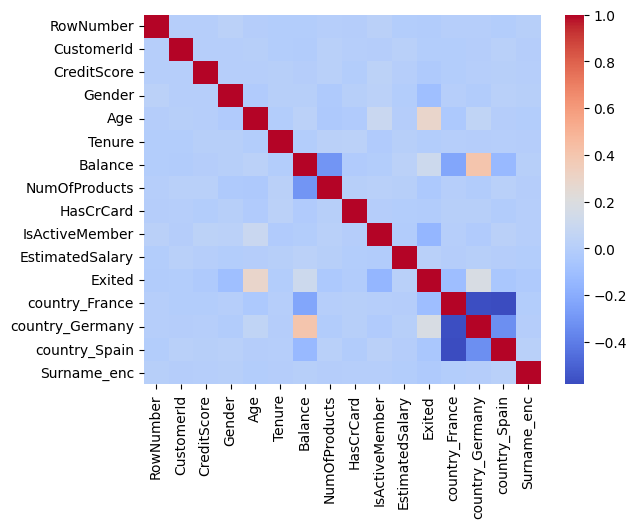

In [234]:
#new correlation table/matrix
corr = churn_train.corr()
corr
sns.heatmap(corr, cmap = 'coolwarm')

In [235]:
#products with correlation
eps = 1e-6

churn_train['bal_per_product'] = churn_train.Balance/(churn_train.NumOfProducts + eps)
churn_train['bal_by_est_salary'] = churn_train.Balance/(churn_train.EstimatedSalary + eps)
churn_train['tenure_age_ratio'] = churn_train.Tenure/(churn_train.Age + eps)
churn_train['age_surname_mean_churn'] = np.sqrt(churn_train.Age) * churn_train.Surname_enc

In [236]:
new_cols = ['bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']

churn_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<Axes: >

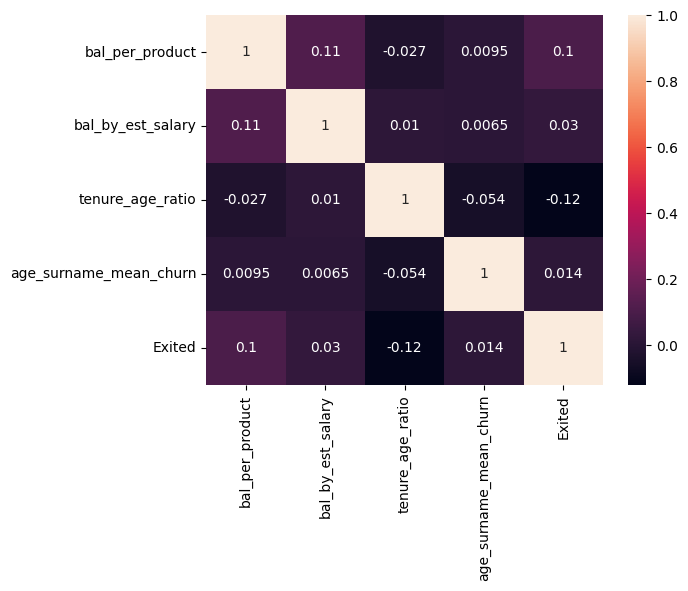

In [237]:
#linear association of new columns with "exited" to see weights
sns.heatmap(churn_train[new_cols + ['Exited']].corr(), annot=True)

In [238]:
#notice bal per product and tenure age ratio

In [239]:
churn_val['bal_per_product'] = churn_val.Balance/(churn_val.NumOfProducts + eps)
churn_val['bal_by_est_salary'] = churn_val.Balance/(churn_val.EstimatedSalary + eps)
churn_val['tenure_age_ratio'] = churn_val.Tenure/(churn_val.Age + eps)
churn_val['age_surname_mean_churn'] = np.sqrt(churn_val.Age) * churn_val.Surname_enc
churn_test['bal_per_product'] = churn_test.Balance/(churn_test.NumOfProducts + eps)
churn_test['bal_by_est_salary'] = churn_test.Balance/(churn_test.EstimatedSalary + eps)
churn_test['tenure_age_ratio'] = churn_test.Tenure/(churn_test.Age + eps)
churn_test['age_surname_mean_churn'] = np.sqrt(churn_test.Age) * churn_test.Surname_enc

In [240]:
# initialize the standard scaler
sc = StandardScaler()
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']
#scale continuous columns
cols_to_scale = cont_vars
sc_X_train = sc.fit_transform(churn_train[cols_to_scale])
#array to df
sc_X_train = pd.DataFrame(data=sc_X_train, columns=cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [241]:
#scaling validation + training set
sc_X_val = sc.transform(churn_val[cols_to_scale])
sc_X_test = sc.transform(churn_test[cols_to_scale])
#array to df
sc_X_val = pd.DataFrame(data=sc_X_val, columns=cols_to_scale)
sc_X_test = pd.DataFrame(data=sc_X_test, columns=cols_to_scale)

In [242]:
#featureset and taregt for RFE model
y = churn_train['Exited'].values
X = churn_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars
X.columns

Index(['Gender', 'HasCrCard', 'IsActiveMember', 'country_France',
       'country_Germany', 'country_Spain', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

In [243]:
x = LabelEncoder()
churn['Gender'] = x.fit_transform(churn['Gender'])
#churn

In [244]:
# for logistics regression
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe = rfe.fit(X.values, y)

print(rfe.support_)
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature
print(rfe.ranking_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[ True  True  True  True  True  True False  True False False  True False
  True False False  True False]
[1 1 1 1 1 1 5 1 4 6 1 8 1 7 3 1 2]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [245]:
# Logistic regression
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'Age',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

In [246]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]
# Using categorical features and scaled numerical features
X_train = np.concatenate((churn_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis=1)
X_val = np.concatenate((churn_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis=1)
X_test = np.concatenate((churn_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis=1)
# print the shapes
X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [247]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts=True)
weights = np.max(num_samples)/num_samples

weights_dict = dict()
class_labels = [0,1]
# Weights associated with classes
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

In [248]:
#Defining model
lr = LogisticRegression(C=1.0, penalty='l2', class_weight=weights_dict, n_jobs=-1)
#train
lr.fit(X_train, y_train)
print(f'Confusion Matrix: \n{confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

Confusion Matrix: 
[[591 251]
 [ 73 165]]
Area Under Curve: 0.6975887742270305
Recall score: 0.6932773109243697
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       842
           1       0.40      0.69      0.50       238

    accuracy                           0.70      1080
   macro avg       0.64      0.70      0.64      1080
weighted avg       0.78      0.70      0.72      1080



In [249]:
pip install utils

In [250]:
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline


In [251]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [252]:
from sklearn.svm import SVC

In [253]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [254]:
LGB = LGBMClassifier()
# Define hyperparameters for the LightGBM model
params = {
    'objective': 'binary',  # For binary classification
    'metric': 'binary_error',  # Metric to optimize (binary classification error)
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Maximum number of leaves in one tree
    'learning_rate': 0.05,
    'feature_fraction': 0.9,  # Fraction of features to use in each iteration
}

# Create the LightGBM model
model = LGB.fit(X_train, y)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
#y_pred_binary = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
#conf_matrix = confusion_matrix(y_test, y_pred_binary)
#lass_report = classification_report(y_test, y_pred_binary)

# Print the evaluation results
print("Accuracy:", accuracy)
#print("\nConfusion Matrix:\n", conf_matrix)
#print("\nClassification Report:\n", class_report)

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203030 -> initscore=-1.367461
[LightGBM] [Info] Start training from score -1.367461
Accuracy: 0.859


In [255]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
model = XGB.fit(X_train, y)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
#y_pred_binary = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
#conf_matrix = confusion_matrix(y_test, y_pred_binary)
#lass_report = classification_report(y_test, y_pred_binary)

# Print the evaluation results
print("Accuracy:", accuracy)

Accuracy: 0.842


In [256]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'num_leaves': [15, 31, 50],           # Maximum number of leaves in one tree
    'learning_rate': [0.05, 0.1, 0.2],   # Learning rate
    'n_estimators': [50, 100, 200],       # Number of boosting rounds
    'max_depth': [3, 5, 7],              # Maximum depth of a tree
    'min_child_samples': [10, 20, 30],   # Minimum number of samples in a leaf
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(objective='binary', metric='binary_error', boosting_type='gbdt')

# Create a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from the search
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
LGBM_y_pred = best_model.predict(X_test)
LGBM_y_pred_Prob = best_model.predict_proba(X_test)
# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203030 -> initscore=-1.367461
[LightGBM] [Info] Start training from score -1.367461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

GridSearchCV(cv=3,
             estimator=LGBMClassifier(metric='binary_error',
                                      objective='binary'),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'min_child_samples': [10, 20, 30],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [15, 31, 50]},
             scoring='accuracy', verbose=2)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 15}
Accuracy: 0.842

Confusion Matrix:
 [[761  48]
 [110  81]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91       809
           1       0.63      0.42      0.51       191

    accuracy                           0.84      1000
   macro avg       0.75      0.68      0.71      1000
weighted avg       0.83      0.84      0.83      1000



In [257]:
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5],
}

# Create an XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Create a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from the search
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Accuracy: 0.855

Confusion Matrix:
 [[780  29]
 [116  75]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       809
           1       0.72      0.39      0.51       191

    accuracy                           0.85      1000
   macro avg       0.80      0.68      0.71      1000
weighted avg       0.84      0.85      0.84      1000



In [258]:
import xgboost as xgb
params = {
    'learning_rate': 0.2,
    'max_depth': 3,
    'min_child_weight': 1,
    'n_estimators': 100
}
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', params=params)

model.fit(X_train,y_train)

predictionsXGB = model.predict(X_test)

[14:50:25] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 3,
                      'min_child_weight': 1, 'n_estimators': 100},
              predictor=None, ...)

In [259]:
#LGBMPreds = pd.DataFrame(data=LGBM_y_pred, columns=['Prediction'])
LGBMPreds = pd.Series(LGBM_y_pred, name="Predictions")
LGBM_y_pred_Prob = pd.Series
results = pd.concat([churn_test_CUSTID,LGBMPreds.reindex(churn_test_CUSTID.index)], axis=1)


In [260]:
# Make predictions on the test data using the best model
LGBM_y_pred = best_model.predict(X_test)
LGBM_y_pred_Prob = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class (class 1)

In [261]:


# Create new columns in the 'churn' dataframe for predictions and prediction probabilities
churn_test_CUSTID['Predictions'] = LGBM_y_pred
churn_test_CUSTID['Predictions_Prob'] = LGBM_y_pred_Prob

# Display the updated 'churn' dataframe with predictions

churn_test_CUSTID

,CustomerId,Surname,Predictions,Predictions_Prob
6252,15687492,Anderson,0,0.089087
4684,15736963,Herring,0,0.003096
1731,15721730,Amechi,0,0.244779
4742,15762134,Liang,0,0.194523
4521,15648898,Chuang,0,0.099052
...,...,...,...,...
3921,15743871,Nkemdirim,1,0.637709
6685,15606861,Tien,0,0.023115
3194,15673539,Napolitani,0,0.090223
1941,15645956,Jideofor,0,0.354923
